# HUE Full Pipeline — Large Network Demo

This notebook demonstrates the complete HUE pipeline on a larger synthetic network (1,500+ nodes), including:

- Visualizing selected core nodes
- Core clustering and similarity matrix
- Community detection and evaluation
- Comparison of core selection strategies
- Embedding heatmap

> **Paper:** Vaghefi, M. S., & Nazareth, D. L. (2021). *Mining Online Social Networks.* JAIS, 22(6).

## 1. Setup and Graph Generation

In [1]:
from fa2 import ForceAtlas2
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from hue_embedding import HUE

%matplotlib inline
np.random.seed(42)

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=1.0,
    strongGravityMode=True,
    gravity=0.5,
    verbose=True)

In [2]:
# 7 communities of varying sizes
sizes = [230, 225, 225, 198, 267, 165, 190]
G = nx.random_partition_graph(sizes, p_in=0.4, p_out=0.08, seed=42)

# Ground truth labels
ground_truth = []
for i, size in enumerate(sizes):
    ground_truth.extend([i] * size)
ground_truth = np.array(ground_truth)

print(f"Nodes: {G.number_of_nodes():,}")
print(f"Edges: {G.number_of_edges():,}")
print(f"Communities: {len(sizes)}")
print(f"Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.1f}")

Nodes: 1,500
Edges: 142,188
Communities: 7
Average degree: 189.6


## 2. Compute Layout

In [3]:
pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=500)

100%|████████████████████████████████████████| 500/500 [00:03<00:00, 140.49it/s]

BarnesHut Approximation  took  1.45  seconds
Repulsion forces  took  1.50  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.37  seconds
AdjustSpeedAndApplyForces step  took  0.14  seconds


## 3. Fit HUE

In [4]:
model = HUE(
    n_cores=0.15,
    core_selection='random',
    random_state=42
)
embedding = model.fit_transform(G)

print(f"Embedding shape: {embedding.shape}")
print(f"Communities found: {model.n_clusters_}")
print(f"Core nodes: {len(model.core_nodes_)}")
print(f"\nCluster composition:")
for label, members in model.clusters_.items():
    print(f"  Cluster {label}: {len(members)} cores")

/Users/sharifvaghefm/Dropbox/mygit/Projects/HUE/examples/hue_embedding/core.py:392: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  bip_adj = nx.adjacency_matrix(bip_graph, bip_nodes_order)
/Users/sharifvaghefm/Dropbox/mygit/Projects/HUE/examples/hue_embedding/core.py:401: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  user_adj = nx.adjacency_matrix(user_graph, user_node_order)
/Users/sharifvaghefm/Dropbox/mygit/Projects/HUE/examples/hue_embedding/core.py:534: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  full_adj = nx.adjacency_matrix(G, all_nodes).tolil()


Embedding shape: (1500, 7)
Communities found: 7
Core nodes: 225

Cluster composition:
  Cluster 0: 44 cores
  Cluster 1: 40 cores
  Cluster 2: 32 cores
  Cluster 3: 31 cores
  Cluster 4: 28 cores
  Cluster 5: 26 cores
  Cluster 6: 24 cores


## 4. Visualize Core Nodes

Highlight the selected core nodes (squares) among all other nodes.

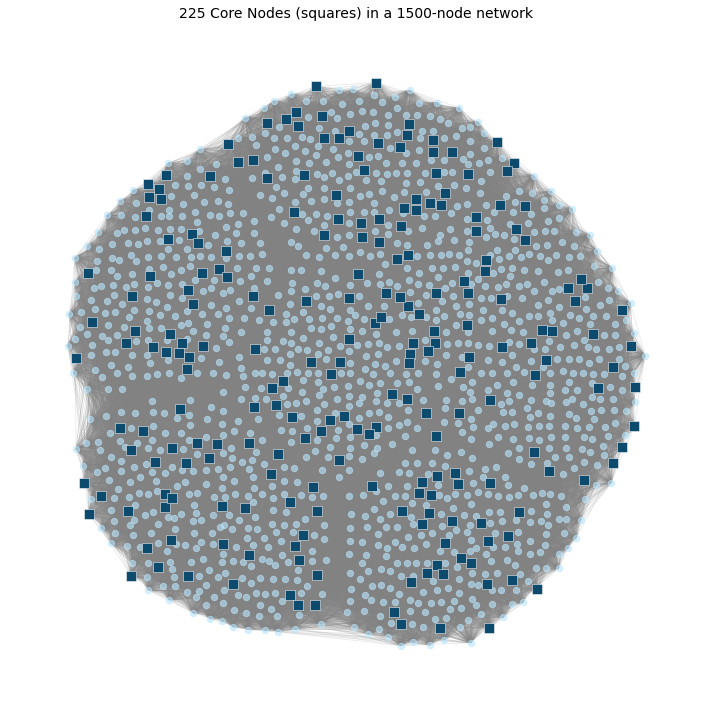

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color='grey', ax=ax)

core_set = set(model.core_nodes_)
regular = [n for n in G.nodes() if n not in core_set]

nx.draw_networkx_nodes(G, pos, nodelist=regular,
                       node_size=40, node_color='#BAE6FD', alpha=0.6, ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=list(core_set),
                       node_size=100, node_color='#0C4A6E',
                       node_shape='s', edgecolors='white', linewidths=0.5, ax=ax)

ax.set_title(f'{len(core_set)} Core Nodes (squares) in a {G.number_of_nodes()}-node network',
             fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

## 5. Visualize Core Clusters

Color core nodes by their discovered cluster. Regular nodes are shown in light grey.

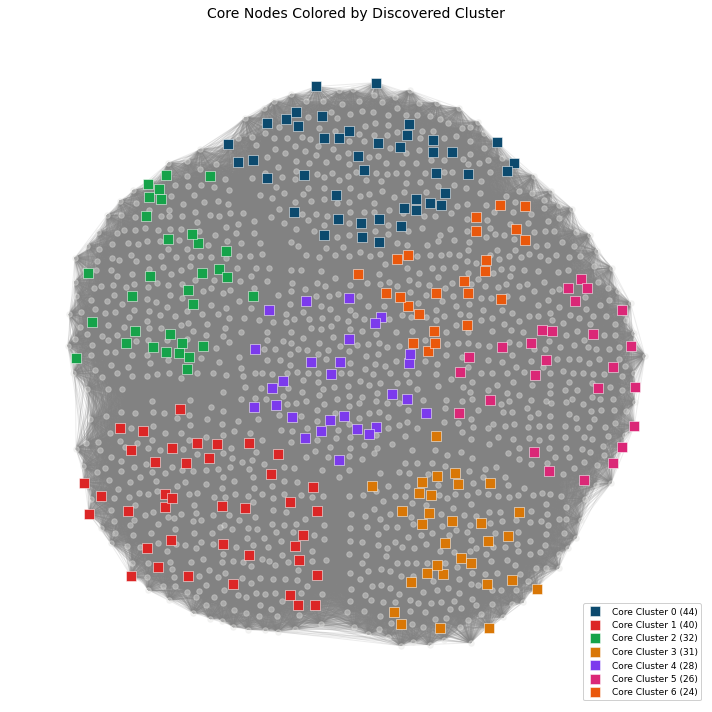

In [6]:
cluster_colors = ['#0C4A6E', '#DC2626', '#16A34A', '#D97706', '#7C3AED',
                   '#DB2777', '#EA580C', '#0891B2', '#4F46E5', '#CA8A04',
                   '#65A30D', '#0D9488']

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color='grey', ax=ax)

# Regular nodes
nx.draw_networkx_nodes(G, pos, nodelist=regular,
                       node_size=30, node_color='#E5E5E3', alpha=0.4, ax=ax)

# Core nodes colored by cluster
core_labels = model.get_cluster_labels()
for cid in range(model.n_clusters_):
    members = [n for n, c in core_labels.items() if c == cid]
    color = cluster_colors[cid % len(cluster_colors)]
    nx.draw_networkx_nodes(G, pos, nodelist=members,
                           node_size=120, node_color=color,
                           node_shape='s', edgecolors='white', linewidths=0.5,
                           label=f'Core Cluster {cid} ({len(members)})', ax=ax)

ax.set_title('Core Nodes Colored by Discovered Cluster', fontsize=14)
ax.legend(fontsize=9, loc='lower right', framealpha=0.9)
ax.axis('off')
plt.tight_layout()
plt.show()

## 6. Core Similarity Matrix

The pairwise structural similarity between core nodes — the foundation for clustering.

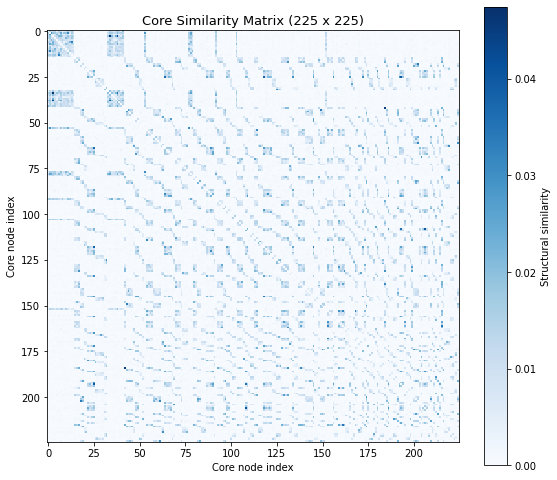

Similarity range: [0.0000, 0.0475]
Non-zero entries: 50400 / 50625


In [7]:
sim = model.similarity_matrix_.toarray()
np.fill_diagonal(sim, 0)

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(sim, cmap='Blues', interpolation='nearest')
ax.set_title(f'Core Similarity Matrix ({sim.shape[0]} x {sim.shape[1]})', fontsize=13)
ax.set_xlabel('Core node index')
ax.set_ylabel('Core node index')
plt.colorbar(im, ax=ax, label='Structural similarity')
plt.tight_layout()
plt.show()

print(f"Similarity range: [{sim[sim > 0].min():.4f}, {sim.max():.4f}]")
print(f"Non-zero entries: {np.count_nonzero(sim)} / {sim.size}")

## 7. Community Detection — All Nodes

Use KMeans on the HUE embedding to assign every node to a community.

In [8]:
kmeans = KMeans(n_clusters=len(sizes), random_state=0, n_init=10)
predicted = kmeans.fit_predict(embedding.values)

ari = adjusted_rand_score(ground_truth, predicted)
nmi = normalized_mutual_info_score(ground_truth, predicted)

print(f"Adjusted Rand Index:          {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")
print(f"\nPredicted cluster sizes: {sorted([np.sum(predicted == i) for i in range(len(sizes))], reverse=True)}")
print(f"True cluster sizes:      {sorted(sizes, reverse=True)}")

Adjusted Rand Index:          0.9941
Normalized Mutual Information: 0.9913

Predicted cluster sizes: [267, 228, 227, 224, 198, 191, 165]
True cluster sizes:      [267, 230, 225, 225, 198, 190, 165]


### Visualize: Ground Truth vs HUE Prediction

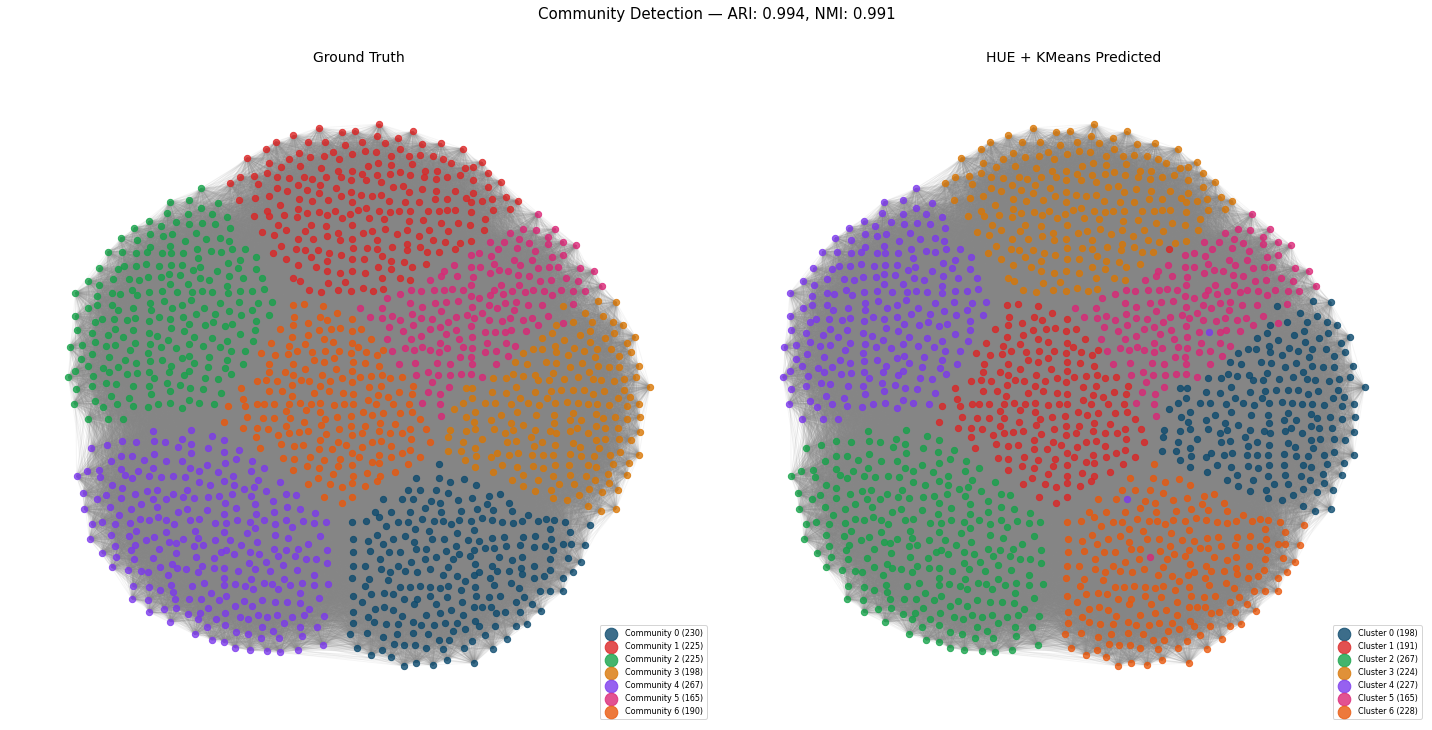

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
cmap_colors = ['#0C4A6E', '#DC2626', '#16A34A', '#D97706', '#7C3AED', '#DB2777', '#EA580C']

for i in range(len(sizes)):
    mask = [n for n in G.nodes() if ground_truth[n] == i]
    nx.draw_networkx_nodes(G, pos, nodelist=mask, node_size=40,
                           node_color=cmap_colors[i], alpha=0.8, ax=axes[0],
                           label=f'Community {i} ({sizes[i]})')
nx.draw_networkx_edges(G, pos, alpha=0.08, edge_color='grey', ax=axes[0])
axes[0].set_title('Ground Truth', fontsize=14)
axes[0].legend(fontsize=8, loc='lower right', markerscale=2)
axes[0].axis('off')

for i in range(len(sizes)):
    mask = [n for n in G.nodes() if predicted[n] == i]
    nx.draw_networkx_nodes(G, pos, nodelist=mask, node_size=40,
                           node_color=cmap_colors[i], alpha=0.8, ax=axes[1],
                           label=f'Cluster {i} ({len(mask)})')
nx.draw_networkx_edges(G, pos, alpha=0.08, edge_color='grey', ax=axes[1])
axes[1].set_title('HUE + KMeans Predicted', fontsize=14)
axes[1].legend(fontsize=8, loc='lower right', markerscale=2)
axes[1].axis('off')

plt.suptitle(f'Community Detection — ARI: {ari:.3f}, NMI: {nmi:.3f}', fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

## 8. Embedding Heatmap

Visualize the full embedding matrix — rows sorted by ground truth community. Block-diagonal structure = successful community recovery.

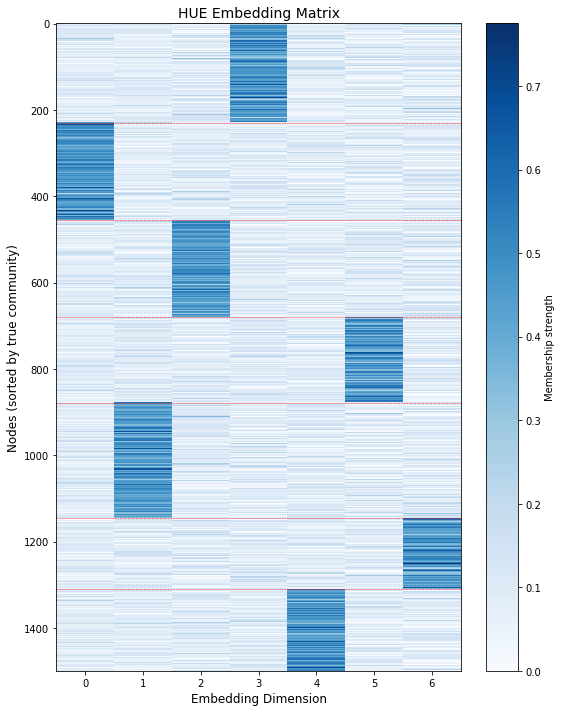

In [10]:
sort_idx = np.argsort(ground_truth)
sorted_emb = embedding.values[sort_idx]

fig, ax = plt.subplots(figsize=(8, 10))
im = ax.imshow(sorted_emb, aspect='auto', cmap='Blues', interpolation='nearest')
ax.set_xlabel('Embedding Dimension', fontsize=12)
ax.set_ylabel('Nodes (sorted by true community)', fontsize=12)
ax.set_title('HUE Embedding Matrix', fontsize=14)

# Mark community boundaries
cumsum = np.cumsum(sizes)
for c in cumsum[:-1]:
    ax.axhline(y=c, color='red', linewidth=0.5, linestyle='--')

plt.colorbar(im, ax=ax, label='Membership strength')
plt.tight_layout()
plt.show()

## 9. t-SNE Projection

/Users/sharifvaghefm/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sharifvaghefm/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


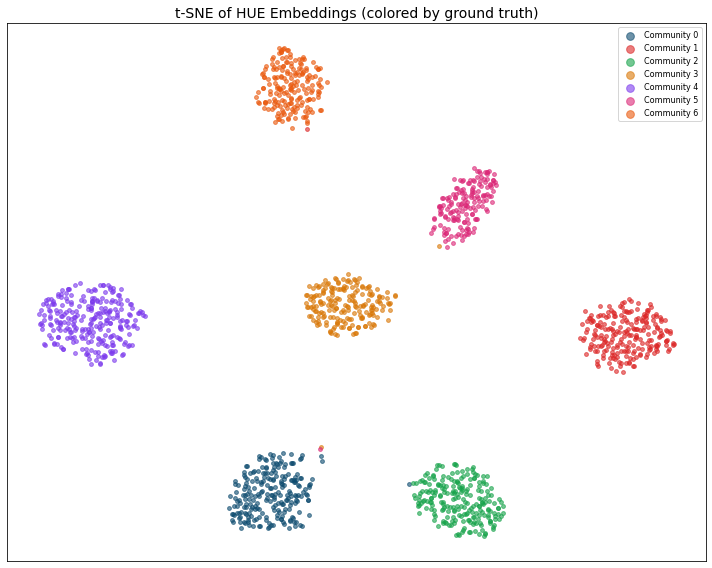

In [11]:
tsne = TSNE(n_components=2, random_state=0, perplexity=40)
projection = tsne.fit_transform(embedding.values)

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(sizes)):
    mask = ground_truth == i
    ax.scatter(projection[mask, 0], projection[mask, 1],
               c=cmap_colors[i], label=f'Community {i}', s=15, alpha=0.6)

ax.set_title('t-SNE of HUE Embeddings (colored by ground truth)', fontsize=14)
ax.legend(fontsize=8, markerscale=2)
ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

## 10. Core Selection: Random vs Degree

In [12]:
for strategy in ['random', 'degree']:
    m = HUE(n_cores=0.15, core_selection=strategy, random_state=42)
    emb = m.fit_transform(G)
    pred = KMeans(n_clusters=len(sizes), random_state=0, n_init=10).fit_predict(emb.values)
    ari = adjusted_rand_score(ground_truth, pred)
    nmi = normalized_mutual_info_score(ground_truth, pred)
    print(f"{strategy:>10}: ARI={ari:.4f}  NMI={nmi:.4f}  clusters={m.n_clusters_}  cores={len(m.core_nodes_)}")

/Users/sharifvaghefm/Dropbox/mygit/Projects/HUE/examples/hue_embedding/core.py:392: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  bip_adj = nx.adjacency_matrix(bip_graph, bip_nodes_order)
/Users/sharifvaghefm/Dropbox/mygit/Projects/HUE/examples/hue_embedding/core.py:401: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  user_adj = nx.adjacency_matrix(user_graph, user_node_order)
/Users/sharifvaghefm/Dropbox/mygit/Projects/HUE/examples/hue_embedding/core.py:534: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  full_adj = nx.adjacency_matrix(G, all_nodes).tolil()


    random: ARI=0.9941  NMI=0.9913  clusters=7  cores=225


/Users/sharifvaghefm/Dropbox/mygit/Projects/HUE/examples/hue_embedding/core.py:392: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  bip_adj = nx.adjacency_matrix(bip_graph, bip_nodes_order)
/Users/sharifvaghefm/Dropbox/mygit/Projects/HUE/examples/hue_embedding/core.py:401: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  user_adj = nx.adjacency_matrix(user_graph, user_node_order)
/Users/sharifvaghefm/Dropbox/mygit/Projects/HUE/examples/hue_embedding/core.py:534: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  full_adj = nx.adjacency_matrix(G, all_nodes).tolil()


    degree: ARI=0.5225  NMI=0.5428  clusters=7  cores=225


## 11. Using Two Separate Networks (`fit_from_networks`)

In real social network data, the bipartite structure is already known: users follow social pages, and users are connected to each other. Instead of building a single graph and letting HUE extract the bipartite structure, you can provide the two networks directly.

This is the **recommended approach** for real data — social pages with high follower counts are natural cores that represent specific preferences.

Below we simulate this workflow by splitting our synthetic graph into a bipartite network (users → pages) and a user-to-user network.

In [13]:
import random
from scipy.sparse import csr_matrix

# Simulate: pick 60 high-degree nodes as "social pages" (cores)
# In real data, these would be accounts like @nytimes, @espn, etc.
degrees = dict(G.degree())
pages = sorted(degrees, key=degrees.get, reverse=True)[:60]
users = [n for n in G.nodes() if n not in set(pages)]

print(f"Pages (cores): {len(pages)}")
print(f"Users: {len(users)}")

# Build bipartite adjacency: users × pages
# Entry (i, j) = 1 means user i follows page j
bip_graph = nx.DiGraph()
page_set = set(pages)
for u in users:
    for neighbor in G.neighbors(u):
        if neighbor in page_set:
            bip_graph.add_edge(u, neighbor)

bip_adj = nx.bipartite.biadjacency_matrix(bip_graph, users, pages)

# Build user-to-user adjacency
user_subgraph = G.subgraph(users)
usr_adj = nx.adjacency_matrix(user_subgraph, users)

print(f"Bipartite shape: {bip_adj.shape}  (users × pages)")
print(f"User adj shape:  {usr_adj.shape}  (users × users)")

# Fit HUE from two separate networks
import numpy as np
model_2net = HUE(random_state=42)
emb_2net = model_2net.fit_from_networks(
    bip_adj, usr_adj,
    user_ids=np.array(users),
    core_ids=np.array(pages)
)

print(f"\nEmbedding shape: {emb_2net.shape}")
print(f"Communities found: {model_2net.n_clusters_}")
print(f"\nCluster composition (which pages ended up together):")
for label, members in model_2net.clusters_.items():
    print(f"  Cluster {label}: {len(members)} pages")

# Evaluate community detection
pred_2net = KMeans(n_clusters=len(sizes), random_state=0, n_init=10).fit_predict(emb_2net.values)
# Map user indices back to ground truth
gt_users = np.array([ground_truth[u] for u in users])
ari_2net = adjusted_rand_score(gt_users, pred_2net)
nmi_2net = normalized_mutual_info_score(gt_users, pred_2net)
print(f"\nARI: {ari_2net:.4f}, NMI: {nmi_2net:.4f}")

Pages (cores): 60
Users: 1440


/var/folders/c1/l245nbgx5g96h5n3bn2wfvm1h6c8hp/T/ipykernel_91486/2464235839.py:22: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  bip_adj = nx.bipartite.biadjacency_matrix(bip_graph, users, pages)
/var/folders/c1/l245nbgx5g96h5n3bn2wfvm1h6c8hp/T/ipykernel_91486/2464235839.py:26: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  usr_adj = nx.adjacency_matrix(user_subgraph, users)


Bipartite shape: (1440, 60)  (users × pages)
User adj shape:  (1440, 1440)  (users × users)

Embedding shape: (1440, 4)
Communities found: 4

Cluster composition (which pages ended up together):
  Cluster 0: 46 pages
  Cluster 1: 5 pages
  Cluster 2: 5 pages
  Cluster 3: 4 pages

ARI: 0.1705, NMI: 0.2126


## Summary

- HUE selects core nodes and discovers communities through structural similarity
- The similarity matrix is a **weighted graph** of cores — modularity-based clustering finds preference communities
- ForceAtlas2 layout reveals community structure clearly
- Core clusters are visually coherent — cores in the same cluster sit near each other
- For real social network data, use `fit_from_networks()` with two separate networks (bipartite + user graph)
- Social media pages sorted by follower count make the best cores